# PyAT Primer

## Introduction

The Accelerator Toolbox (AT) is a toolbox of functions in Matlab for
charged particle beam simulation. It was created by Andrei Terebilo in
the late 1990’s. The original papers still serve as a good introduction
to AT. The AT described in those papers is AT1.3, the latest version
produced by Terebilo. The next version of AT is considered AT2.0. Here
we provide examples showing some of the changes from AT1.3, but also
serving as an introduction for someone just starting AT.

### Coordinates

The 6-d phase space coordinates used in AT are as follows:

```{math}
\vec Z = \begin{pmatrix} x \\ \frac{p_x}{p_0}=x'(1+\delta) \\ y \\ \frac{p_y}{p_0}=y'(1+\delta) \\ \delta=\frac{\left(p_z-p_0\right)}{p_0} \\ c\tau\end{pmatrix}
```
$p_0$ is the reference momentum. $\tau$ is the
time lag relative to the ideal particle.

## Creation of Elements and Lattices

In [2]:
import at
import at.plot
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import pi
mpl.rcParams["figure.figsize"] = [9.0, 6.0]

A lattice in AT is a object of the {py:class}`.Lattice` class containing the lattice elements. These elements may be created using element creation functions. These functions output objects inheriting from the {py:class}`.Element` base class. For example, a quadrupole may be created with the function {py:class}`.Quadrupole`.

Help on this element can be displayed with:

In [4]:
at.Quadrupole?

Init signature:
at.Quadrupole(
    family_name: 'str',
    length: 'float',
    k: 'float | None' = 0.0,
    **kwargs,
)
Docstring:      Quadrupole element
Init docstring:
Quadrupole(FamName, Length, Strength=0, **keywords)

Args:
    family_name:    Name of the element
    length:         Element length [m]
    k:              Focusing strength [mˆ-2]

Keyword Arguments:
    PolynomB:           straight multipoles
    PolynomA:           skew multipoles
    MaxOrder=1:         Number of desired multipoles
    NumIntSteps=10:     Number of integration steps
    FringeQuadEntrance: 0: no fringe field effect (default)

      1: Lee-Whiting's thin lens limit formula

      2: elegant-like
    FringeQuadExit:     See ``FringeQuadEntrance``
    fringeIntM0:        Integrals for FringeQuad method 2
    fringeIntP0:
    KickAngle:          Correction deviation angles (H, V)
    FieldScaling:       Scaling factor applied to the magnetic field
      (*PolynomA* and *PolynomB*)

Default PassMeth

In [2]:
QF=at.Quadrupole('QF',0.5,1.2)
print(QF)

Quadrupole:
	FamName : QF
	Length : 0.5
	PassMethod : StrMPoleSymplectic4Pass
	NumIntSteps : 10
	MaxOrder : 1
	PolynomA : [0. 0.]
	PolynomB : [0.  1.2]
	K : 1.2


We note that the family name of this quadrupole is ’QF’ and the pass
method is `QuadMPoleFringePass`. The fields following are parameters
necessary to be able to pass an electron through this quadrupole (i.e.,
the set of arguments required by the pass method). We now create some
other elements needed in a FODO lattice:

In [3]:
Dr = at.Drift('Dr', 0.5)
HalfDr = at.Drift('Dr2', 0.25)
QD = at.Quadrupole('QD', 0.5, -1.2)
Bend = at.Dipole('Bend', 1, 2*pi/40)

In addition to **Quadrupole** that we already saw, we have created a
drift (region with no magnetic field), using **Drift**. Besides the
family name, the only other needed field is the length. Since we split
the cell in the center of the drift, we have also created a half drift
element. The drifts are 0.5 meters long and the half drift is 0.25
meters long. We have defined a sector dipole, or bend magnet using
**Dipole**. The family name is ’Bend’. The second field is the length
of the magnet and we have given it a length of 1 meter. Next is the
bending angle. We have defined just an arc of a FODO lattice here, so we
don’t have to bend by all of $2\pi$ here. We choose to have 20 total
such arcs, for a realistic field strength, and thus we define the
bending angle to be $2\pi/40$ since there are two bends per cell.

A cell of a FODO lattice may now be constructed as follows

In [4]:
FODOcell = at.Lattice([HalfDr, Bend, Dr, QF, Dr, Bend, Dr, QD, HalfDr],
                      name='Simple FODO cell', energy=1E9)
print(FODOcell)

Lattice(<9 elements>, name='Simple FODO cell', energy=1000000000.0, particle=Particle('relativistic'), periodicity=20)


As mentioned, this cell is only 1/20 of a FODO lattice. The entire
lattice may be created by repeating this cell 20 times as follows

In [5]:
FODO = FODOcell*20
print(FODO)

Lattice(<180 elements>, name='Simple FODO cell', energy=1000000000.0, particle=Particle('relativistic'), periodicity=1)


We have now created a valid AT lattice, using drifts, dipoles, and
quadrupoles. We will later add some sextupoles to this lattice, and also
an RF cavity, but one could track particles through this lattice, as is.

For completeness, we list all of the AT element creation functions:
**Aperture**, **Corrector**, **Drift**, **M66**, **Marker**, **Monitor**, **ThinMultipole**, **Multipole**, **Octupole**, **Quadrupole**, **RFcavity**, **Sextupole**, **Wiggler**.

## Lattice Querying and Manipulation

There are many parameters in a storage ring lattice. We need tools to
view these parameters and to change them.

### Selecting elements
We have seen how to concatenate elements to form a lattice. To extract elements, two indexing methods may be used, similar to indexing in numpy arrays:

- Integer array indexing: elements are identified by the array of their indices. For instance, the elements at locations 3 and 7 of `FODOcell` may be selected with:

In [6]:
list(FODOcell[3, 7])

[Quadrupole('QF', 0.5, 1.2), Quadrupole('QD', 0.5, -1.2)]

- Boolean array indexing; elements are identified by a Boolean array, as long as the Lattice, where selected elements are identified by a True value. The same elements as in the previous example may be selected with:

In [7]:
mask=np.zeros(len(FODOcell), dtype=bool)
mask[3] = True
mask[7] = True
list(FODOcell[mask])

[Quadrupole('QF', 0.5, 1.2), Quadrupole('QD', 0.5, -1.2)]

Many AT function have an input argument, usually named 'refpts' using such indexing methods to select the "points of interest" in the function output. Please note that:

- The corresponding locations in the ring are the **entrances** of the selected ring elements,
- as a special case, a value of "len(ring)" (normally out-of-range element) is used to indicate the **exit** of the **last** element (think of it as the entrance of the 2nd turn).

Such indexes can be generated with the **get_cells** function, which returns a boolean index of elements selected by the value of any of their attributes or by an user-supplied check function:

In [8]:
refqf = at.get_cells(FODOcell, 'FamName', 'QF')   # FamName attribute == QF
print(list(FODOcell[refqf]))
refqd = at.get_cells(FODOcell, 'FamName', 'QD')   # FamName attribute == QD
print(list(FODOcell[refqd]))
refbends = at.get_cells(FODOcell, 'BendingAngle') # Existing BendingAngle attribute
print(list(FODOcell[refbends]))

[Quadrupole('QF', 0.5, 1.2)]
[Quadrupole('QD', 0.5, -1.2)]
[Dipole('Bend', 1.0, 0.15707963267948966, 0.0), Dipole('Bend', 1.0, 0.15707963267948966, 0.0)]


Using predefined check functions we can write:

In [9]:
refq1 = at.get_cells(FODOcell, at.checktype(at.Quadrupole))   # class == Quadrupole
print(list(FODOcell[refq1]))
refq2 = at.get_cells(FODOcell, at.checkname('Q[FD]'))         # name matches a pattern
print(list(FODOcell[refq2]))

[Quadrupole('QF', 0.5, 1.2), Quadrupole('QD', 0.5, -1.2)]
[Quadrupole('QF', 0.5, 1.2), Quadrupole('QD', 0.5, -1.2)]


Both methods select the same elements. Since **get_cells** returns numpy boolean arrays, the same result can also be obtained as:

In [10]:
print(list(FODOcell[refqf | refqd]))

[Quadrupole('QF', 0.5, 1.2), Quadrupole('QD', 0.5, -1.2)]


### Iterating over selected elements
The **select** method of the lattice object returns an iterator over the selected elements:

In [11]:
for elem in FODOcell.select(refqf | refqd):
    print(elem)

Quadrupole:
	FamName : QF
	Length : 0.5
	PassMethod : StrMPoleSymplectic4Pass
	NumIntSteps : 10
	MaxOrder : 1
	PolynomA : [0. 0.]
	PolynomB : [0.  1.2]
	K : 1.2
Quadrupole:
	FamName : QD
	Length : 0.5
	PassMethod : StrMPoleSymplectic4Pass
	NumIntSteps : 10
	MaxOrder : 1
	PolynomA : [0. 0.]
	PolynomB : [ 0.  -1.2]
	K : -1.2


### Extracting attribute values
Following the previous example, we can get the quadrupole strengths (PolynomB[1]) with:

In [12]:
np.array([elem.PolynomB[1] for elem in FODOcell.select(refqf | refqd)])

array([ 1.2, -1.2])

The same result is provided by the **get_value_refpts** convenience function:

In [13]:
at.get_value_refpts(FODOcell, refqf | refqd, 'PolynomB', index=1)

array([ 1.2, -1.2])

### Setting attribute values
Similarly, using a the Lattice iterator, we can write:

In [14]:
new_strengths = [1.1, -1.3]
for elem, strength in zip(FODOcell.select(refqf | refqd), new_strengths):
    elem.PolynomB[1] = strength
# Check the result:
np.array([elem.PolynomB[1] for elem in FODOcell.select(refqf | refqd)])

array([ 1.1, -1.3])

Or with the **set_value_refpts** function:

In [15]:
initial_strengths = [1.2, -1.2]
at.set_value_refpts(FODOcell, refqf | refqd, 'PolynomB', initial_strengths, index=1)
# Check the result:
at.get_value_refpts(FODOcell, refqf | refqd, 'PolynomB', index=1)

array([ 1.2, -1.2])

## Tracking

Once a lattice is defined, electrons may be tracked through it.
**lattice_pass** is the function that does the tracking. An example of its
use is as follows:

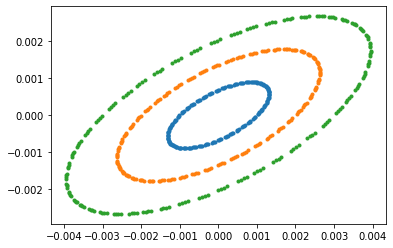

In [16]:
nturns=200
Z01 = np.array([.001, 0, 0, 0, 0, 0])
Z02 = np.array([.002, 0, 0, 0, 0, 0])
Z03 = np.array([.003, 0, 0, 0, 0, 0])
Z1=at.lattice_pass(FODO,Z01,nturns)
Z2=at.lattice_pass(FODO,Z02,nturns)
Z3=at.lattice_pass(FODO,Z03,nturns)
plt.plot(Z1[0, 0, 0, :], Z1[1, 0, 0, :],'.')
plt.plot(Z2[0, 0, 0, :], Z2[1, 0, 0, :],'.')
plt.plot(Z3[0, 0, 0, :], Z3[1, 0, 0, :],'.')

In this example, we started with one initial condition, and all subsequent turns are returned by **lattice_pass**. We may also start with multiple initial conditions:

In [17]:
Z0=np.asfortranarray(np.vstack((Z01,Z02,Z03)).T)
print('Z0.shape:', Z0.shape)
Z=at.lattice_pass(FODO,Z0,nturns)
print(' Z.shape:', Z.shape)

Z0.shape: (6, 3)
 Z.shape: (6, 3, 1, 200)


Now the same plot can be obtained with:

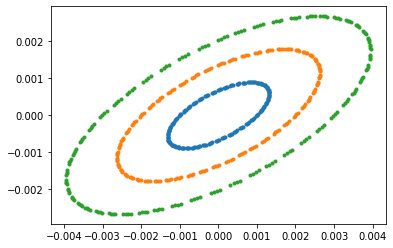

In [18]:
plt.plot(Z[0, 0, 0, :], Z[1, 0, 0, :],'.')
plt.plot(Z[0, 1, 0, :], Z[1, 1, 0, :],'.')
plt.plot(Z[0, 2, 0, :], Z[1, 2, 0, :],'.')

## Computation of beam parameters

Now that particles can be tracked through the lattice, we can use the
tracking to understand different properties of the lattice. First, we
would like to understand the linear properties such as Twiss parameters,
tunes, chromaticities, etc. These can all be calculated with the
function **get_optics**.

In [19]:
[_, beamdata, _] = at.get_optics(FODO, get_chrom=True)

The first argument is the FODO lattice we have created. The second argument says we want to compute the optional chromaticity.

In [20]:
print(beamdata.tune)
print(beamdata.chromaticity)

[0.21993568 0.91777806]
[-6.3404156  -6.19856968]


which tells us the tunes are $\nu_x = 0.2199$ and $\nu_y = 0.9178$ and
the chromaticities are $\xi_x = -6.34$, $\xi_y = -6.20$.

How did AT calculate these quantities? Without digging into the details of **get_optics**, you could still figure it out, just based on the ability to track with the **lattice_pass** function. In fact, AT computes the one-turn transfer matrix by tracking several initial conditions and interpolating. The one turn transfer matrix (here we focus on 4x4) is computed with the function **find_m44** contained within **get_optics**. Calling this on the FODO lattice, we find

In [21]:
m44, _ = at.find_m44(FODO,0)
print(m44)

[[-0.6518562   1.90977797  0.          0.        ]
 [-0.87430341  1.02741279  0.          0.        ]
 [ 0.          0.         -0.1807342  -3.24829821]
 [ 0.          0.          0.41466639  1.91972581]]


The 0 as the second argument tells us to compute with $\delta=0$. We
note that the ring is uncoupled, and computing the eigenvalues of
submatrices, we derive the tunes reported in **get_optics** above.

Computing the tunes with varying $\delta$ allows the computation
of the chromaticity.

Now, suppose we would like to change the tunes in our FODO lattice. We
know that we should change the quadrupole strengths, but we may not know
exactly what values to use.

Here we reach the question of tuning. How do we set the parameters for
these quadrupoles in order to correct the tunes? In principle we have
the tools that we need. We can set the values of the quadrupoles using
the function **set_value_refpts** and then recompute the chromaticity with
**get_optics**. But we still don’t know what values to actually give the
quadrupoles. One could compute the value, or instead use an optimization
routine to vary the values until the correct output tunes are achieved.
This is the approach followed with the function **fit_tune**.

This allows you to vary quadrupole strengths until the desired tune
values are reached. It is used as follows:

First, we need to select two variable quadrupoles. As FODO has been built, the same quadrupole QF is used in each cell, so varying its strength will affect all cells. We just need to select the 1st one in the ring:

In [22]:
refqf = at.get_cells(FODO, at.checkname('QF')) # Select all QFs
refqf1 = np.flatnonzero(refqf)[0]              # Get the 1st one
refqd = at.get_cells(FODO, at.checkname('QD')) # Select all QDs
refqd1 = np.flatnonzero(refqd)[0]              # Get the 1st one

Then we can call the fitting function to set the tunes to $\nu_x = 0.15$ and $\nu_y = 0.75$ using the quadrupoles QF and QD.

In [23]:
at.fit_tune(FODO, refqf, refqd, [0.15, 0.75])


Fitting Tune...
Initial value [0.21993568 0.91777806]
iter# 0 Res. 1.855491062674763e-06
iter# 1 Res. 7.129086834236557e-10
iter# 2 Res. 2.66800409160274e-13
Final value [0.1500004  0.75000033] 



Let's check the result:

In [24]:
[_, beamdata, _]=at.get_optics(FODO)
beamdata.tune

array([0.1500004 , 0.75000033])

Giving satisfactory results for the tunes.

Now, in case you have some experience with storage ring dynamics, you
will know that these negative chromaticity values will lead to
instability and thus our FODO lattice, as is, is not acceptable. To fix
this problem, we add sextupoles to our lattice. We define a focusing and
defocussing sextupoles (0.1 meter long) as follows:

In [25]:
SF = at.Sextupole('SF', 0.1, 0)
SD = at.Sextupole('SD', 0.1, 0)
drs = at.Drift('DRS', 0.2)

Now we want to add these to the lattice at locations where they will be
effective. We will put them in the middle of the 0.5 meter drift
sections: SF before the QF and SD before the QD. Let's locate the drifts:

In [26]:
np.nonzero(at.get_cells(FODOcell, at.checkname("Dr")))

(array([2, 4, 6]),)

We will insert SF in the middle of element 2 and SD in the middle of element 6. Since the Lattice object is derived from the python `list`, we can use all the `list` methods to do this. For instance:

In [27]:
FODOcellSext = FODOcell.copy()
FODOcellSext[6:7] = [drs,SD,drs]
FODOcellSext[2:3] = [drs,SF,drs]
FODOSext = FODOcellSext*20
print(FODOSext)

Lattice(<260 elements>, name='Simple FODO cell', energy=1000000000.0, particle=Particle('relativistic'), periodicity=1)


In [28]:
[_, beamdata, _] = at.get_optics(FODOSext, get_chrom=True)
print(beamdata.tune)
print(beamdata.chromaticity)

[0.1500004  0.75000033]
[-6.14477442 -5.93149994]


The tunes of FODOSext are identical to the ones of FODO. Now we need to tune the sextupoles. For this, we will use the function **fit_chrom**. This function works analogously to **fit_tune** except the sextupoles are varied instead of the quadrupoles. Let's locate the first sextupoles:

In [29]:
refsext = at.get_cells(FODOSext, at.checktype(at.Sextupole)) # Select all sextpoles
refsf,refsd = np.flatnonzero(refsext)[:2]                    # Take the 1st ones

In [30]:
at.fit_chrom(FODOSext, refsf, refsd, [0.5, 0.5])


Fitting Chromaticity...
Initial value [-6.14477442 -5.93149994]
iter# 0 Res. 7.49072769210859e-06
iter# 1 Res. 2.221474425226936e-13
Final value [0.49999953 0.50000002] 



After changing the tunes and fixing the chromaticities, we find:

In [31]:
[_, beamdata, _] = at.get_optics(FODOSext, get_chrom=True)
print(beamdata.tune)
print(beamdata.chromaticity)

[0.1500004  0.75000033]
[0.49999953 0.50000002]


You may have noticed that we ignored two outputs of **get_optics**. They contains linear optics parameters that vary around the ring. These are the Twiss parameters, dispersions, phase advance, and coupling parameters. **elemdata0** is their values at the entrance of the ring, **elemdata** is the values at the selected points of interest. To compute them at all lattice elements, we call:

In [32]:
[elemdata0, beamdata, elemdata] = at.get_optics(FODOcellSext, range(len(FODOcellSext)+1))

Examining **elemdata**, we find:

In [33]:
print('elemdata.shape:', elemdata.shape)
print('elemdata.fields:')
for fld in elemdata.dtype.fields.keys():
    print(fld)

elemdata.shape: (14,)
elemdata.fields:
alpha
beta
mu
R
A
dispersion
closed_orbit
M
s_pos


- ’s_pos’ is the set of $s$ positions,
- ’closed_orbit’ is the $x,x',y,y'$ coordinate vector of the closed orbit,
- ’dispersion’ is the $\eta_x,\eta'_x,\eta_y,\eta'_y$ coordinate vector of dispersion,
- ’M’ is the local $4\times 4$ transfer matrix,
- ’beta’ gives the horizontal and vertical $\beta$ functions,
- ’alpha’ gives the Twiss parameters $\alpha_{x,y}$,
- ’mu’ gives the phase advances (times $2\pi$).

Let us use these results to plot the beta functions around the ring.

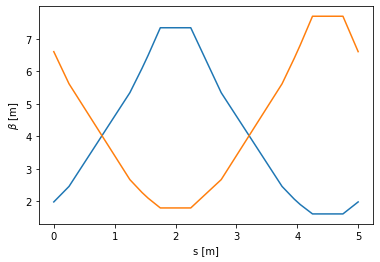

In [34]:
plt.plot(elemdata.s_pos, elemdata.beta)
plt.xlabel('s [m]')
plt.ylabel(r'$\beta$ [m]');

We may also plot the lattice parameters using a dedicated plot function
with the command:

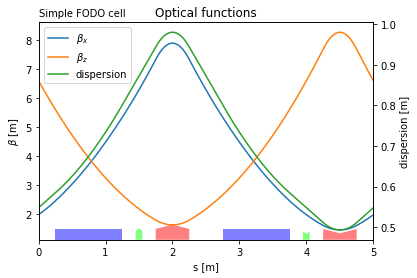

In [35]:
FODOcellSext.plot_beta();

Note that the magnets are displayed below the function, giving a convenient visualization. Also note that the lattice functions are smoother than those we saw before. They have been computed at more positions, by slicing the magnets in the **plot_beta** function.


## Beam sizes

The parameters computed thus far use only the tracking through the
lattice, with no radiation effects. In reality, for electrons, we know
that there are radiation effects which cause a damping and diffusion and
determine equilibrium emittances and beam sizes. This is computed in AT
by the **ohmi_envelope** function using the Ohmi envelope formalism.

In order to use **ohmi_envelope**, we first need to make sure the beam is stable
longitudinally as well, requiring us to add an RF cavity to our FODO
lattice. Let's add an inactive cavity with the command

In [36]:
RFC = at.RFCavity('RFC', 0.0, 0.0, 0.0, 1, 1.0E9, PassMethod='IdentityPass')
FODOSext.insert(0, RFC)
FODOSext.harmonic_number=100

Now, we need to set the values of the RF cavity. This can be done with
the function **set_cavity** as follows

In [37]:
FODOSext.set_cavity(Voltage=0.5E6, Frequency=at.Frf.NOMINAL)
print(RFC)

RFCavity:
	FamName : RFC
	Length : 0.0
	PassMethod : IdentityPass
	Voltage : 500000.0
	Frequency : 299792457.9999997
	HarmNumber : 1
	Energy : 1000000000.0
	TimeLag : 0.0


which says that the each of the 20 RF cavities has a voltage of 25 kV.

**radiation_parameters** gives a summary of the lattice properties, using the classical radiation integrals:

In [38]:
print(at.radiation_parameters(FODOSext))

              Frac. tunes: [0.1500004  0.75000033 0.01845048]
                    Tunes: [5.1500004  4.75000033]
           Chromaticities: [0.49999953 0.50000002]
 Momentum compact. factor: 4.279525e-02
              Slip factor: -4.279499e-02
                   Energy: 1.000000e+09 eV
       Energy loss / turn: 1.389569e+04 eV
 Radiation integrals - I1: 4.279525335274485 m
                       I2: 0.9869604401089351 m^-1
                       I3: 0.15503138340149902 m^-2
                       I4: 0.10559305520899614 m^-1
                       I5: 0.020912844843729298 m^-1
          Mode emittances: [3.48204731e-08            nan            nan]
Damping partition numbers: [0.89301187 1.         2.10698813]
            Damping times: [0.05376156 0.04800971 0.02278594] s
            Energy spread: 0.000330764
             Bunch length: 0.0122102 m
         Cavities voltage: 500000.0 V
        Synchrotron phase: 3.1138 rd
    Synchrotron frequency: 55313.1 Hz


We may now turn radiation ON and call the function **ohmi_envelope** as follows

In [39]:
FODOSext.radiation_on()
_, beamdata, _ = at.ohmi_envelope(FODOSext)
print('beamdata.fields:')
for fld in beamdata.dtype.fields.keys():
    print(fld)

beamdata.fields:
tunes
damping_rates
mode_matrices
mode_emittances


- ’tunes’ gives the 3 tunes of the 6D motion;
- ’damping_rates’,
- ’mode_matrices’ are the sigma matrices of the 3 independent motions
- ’mode_emittances’ are the 3 modal emittances.

An easy way to summarize these results is provided by the **envelope_parameters** function:

In [40]:
print(at.envelope_parameters(FODOSext))

  Frac. tunes (6D motion): [0.14995922 0.75000148 0.0184657 ]
                   Energy: 1.000000e+09 eV
       Energy loss / turn: 1.389569e+04 eV
          Mode emittances: [3.47973047e-08 6.71489487e-37 4.03132669e-06]
Damping partition numbers: [0.89298373 0.99999977 2.1070165 ]
            Damping times: [0.05376455 0.04801088 0.02278618] s
            Energy spread: 0.000330959
             Bunch length: 0.0122209 m
         Cavities voltage: 500000.0 V
        Synchrotron phase: 3.1138 rd
    Synchrotron frequency: 55358.8 Hz


We see that our FODO lattice has an emittance of 34.80 nm, an energy
spread of $3.3\times 10^{-4}$ and a bunch length of 12.2 mm.

## Bibliography
[1](https://www.slac.stanford.edu/pubs/slacpubs/8500/slac-pub-8732.pdf) A. Terebilo *Accelerator Toolbox for Matlab*, SLAC-PUB 8732 (May 2001)

[2](https://inspirehep.net/files/298dd81ab9ce89bfb2a42442b46b0379) A. Terebilo, *Accelerator Modelling with Matlab Accelerator Toolbox*, PAC 2001 Proceedings

[3](https://inspirehep.net/files/8507fec63dc914e41a782b13b831c64e) B. Nash *et al.*, *New Functionality for Beam Dynamics in Accelerator Toolbox*, IPAC 2015

[4](https://journals.aps.org/prab/pdf/10.1103/PhysRevSTAB.2.074001) D. Sagan, D. Rubin, *Linear Analysis of Coupled Lattices*, Phys. Rev. Special Topics - Accelerators
and Beams, Vol 2,(1999)